# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Transfer learning

</font>
</div>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import transforms, datasets, models, utils
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from torchsummary import summary
from torch.utils.data import DataLoader

# Goal

In [ ]:
"""
- We'll train our image classifier to distinguish between the chest X-rays of normal patients and pneumonia patients, 
- We'll use a trained ResNet-50 model to perform transfer learning. 
- We'll have two output units to represent the normal and pneumonia classes.
"""

In [6]:
class AdaptiveConcatPool2d(nn.Module):
    """
    Performs concatenation between Average 2D pooling and Max 2D pooling, so that there is smooth 
    transition from the convolution layers to the fully connected layers with maximum feature information.
    """

    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        output = torch.cat([self.mp(x), self.ap(x)], 1)
        return output

# Inspect the ResNet50

In [ ]:
"""
ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. 
It has 3.8 x 10^9 Floating points operations.
"""

In [5]:
resnet50 = models.resnet50(pretrained=True)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

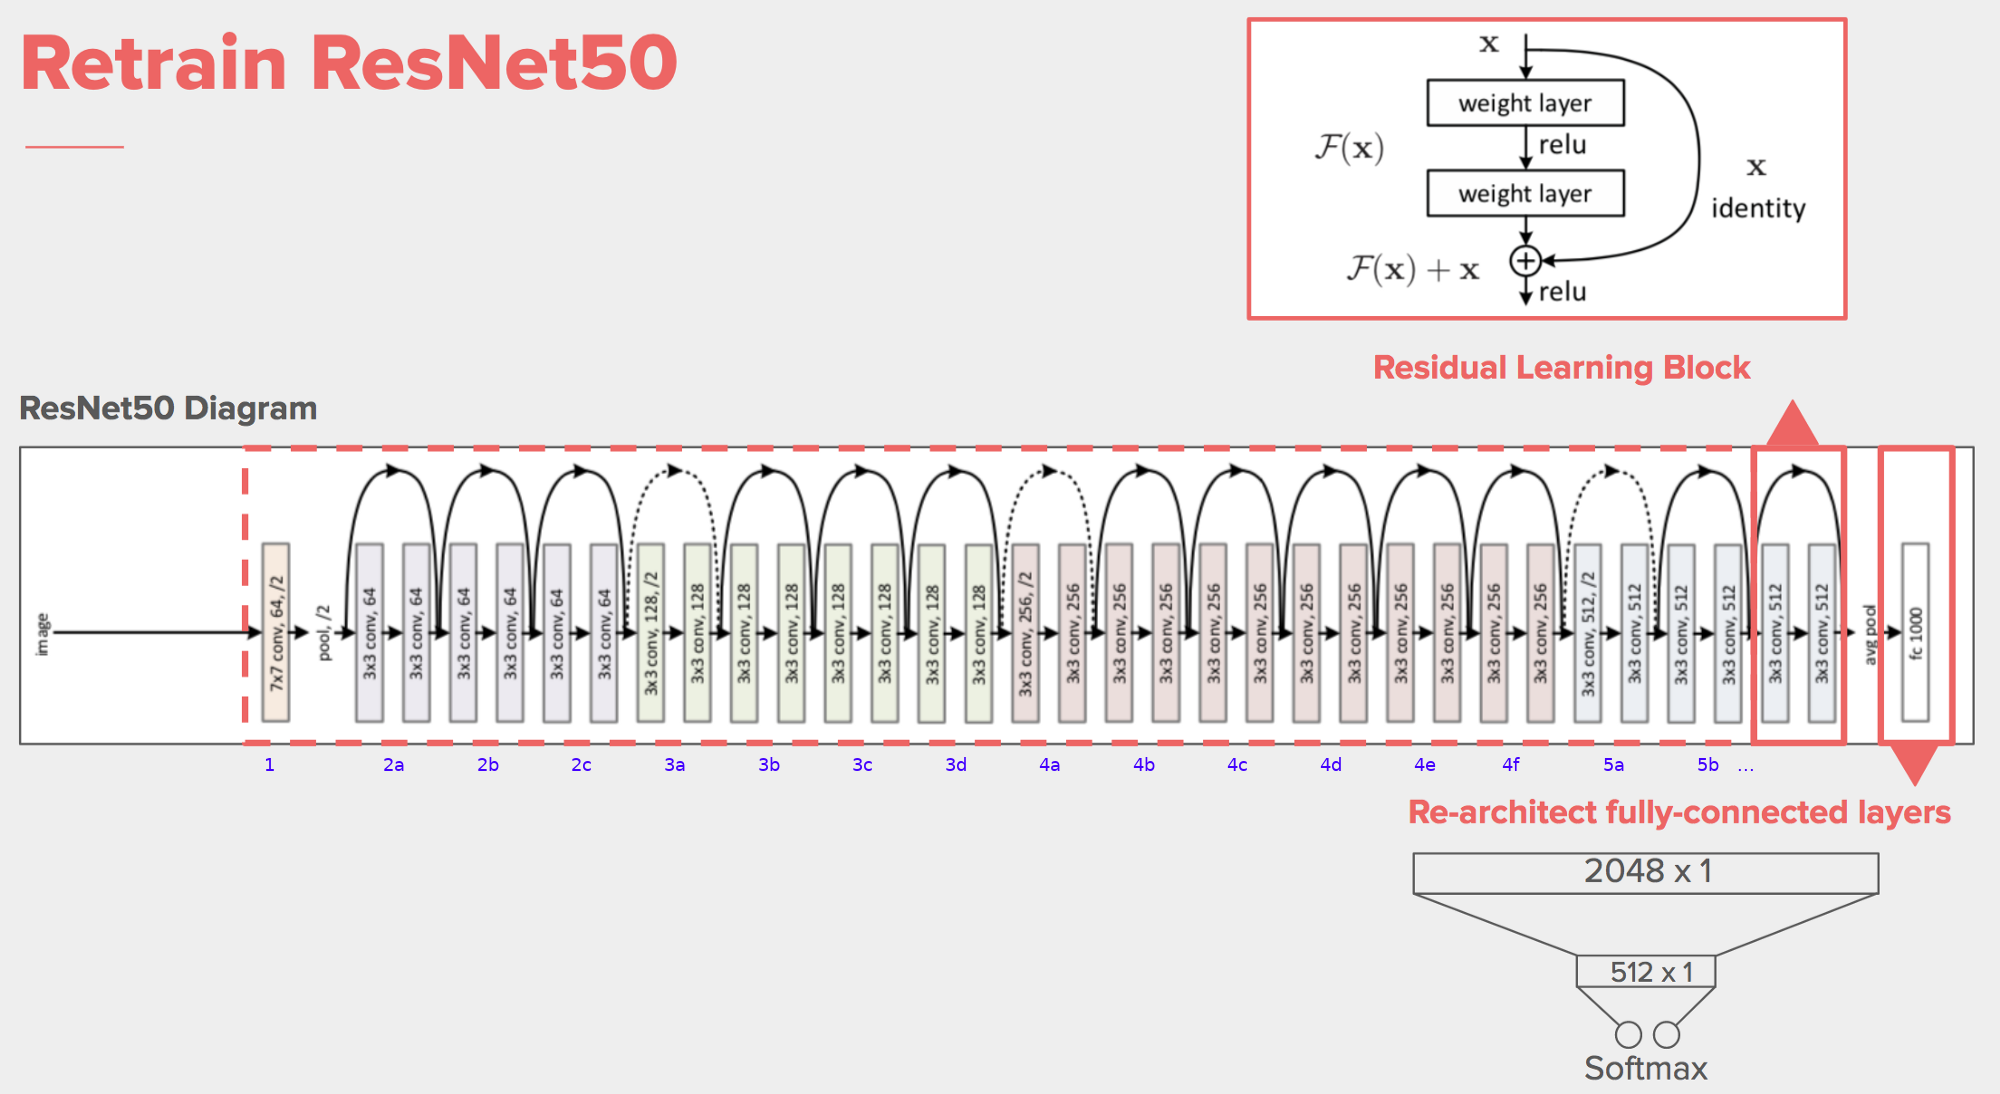

In [ ]:
#https://stackoverflow.com/questions/54207410/how-to-split-resnet50-model-from-top-as-well-as-from-bottom/54207766

# Creating our model based on the ResNet50

In [7]:
def get_model():
    # Get the resnet50 model
    model = models.resnet50(pretrained=True)
    
    # Freeze the model, meanin freeze the weights
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last 2 layers of the ResNet50 model
    # We replaced the average pooling layer with our AdaptiveConcatPool2d layer
    model.avgpool = AdaptiveConcatPool2d()
    # Add a fully connected classifier with two output units for the two classes available. ”
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(4096),
        nn.Dropout(0.5),
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1)
    )
    return model

# Implementing model training

In [ ]:
"""
- In this recipe, we will implement a function for training the model in a single epoch. 
- We will pass in the model, training data, optimizer, and criterion for model training and it will return the training loss.
"""

In [9]:
def train(model, device, train_loader, criterion, optimizer, epoch, writer):
    model.train()
    
    total_loss = 0
    
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        preds = model(data)
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    writer.add_scalar('Train Loss', total_loss/len(train_loader), epoch)
    writer.flush()
    
    return total_loss/len(train_loader)

# Implementing model testing

In [ ]:
"""
- In this recipe, we will define a function to test the model on validation data in an epoch. 
- We will also add utility functions to log some of the misclassifications
from the model by plotting the images and labeling these images in a readable manner.
"""

In [10]:
def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    
    total_loss, correct = 0, 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).cpu().sum()
            
            misclassified_images(pred, writer, target, data, output, epoch)
            
    total_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    writer.add_scalar('Test Loss', total_loss, epoch)
    writer.add_scalar('Accuracy', accuracy, epoch)
    writer.flush()
    
    return total_loss, accuracy

In [11]:
inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

In [12]:
def misclassified_images(pred, writer, target, data, output, epoch, count=10):
    misclassified = (pred != target.data)
    for index, image_tensor in enumerate(data[misclassified][:count]):
        img_name = '{}->Predict-{}x{}-Actual'.format(
                epoch,
                LABEL[pred[misclassified].tolist()[index]],
                LABEL[target.data[misclassified].tolist()[index]], 
            )
        
        writer.add_image(img_name, inv_normalize(image_tensor), epoch)

# Loading the dataset

In [13]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=300, scale=(0.8, 1.1)),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=256),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=300),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=300),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#datadir = '../DATASETS/chest-xray-pneumonia/chest_xray/chest_xray/'
import os
print(os.getcwd())
os.chdir(os.getcwd())
print(os.getcwd())
datadir = '../DATASETS/chest_xray/'
traindir = datadir + 'train/'
validdir = datadir + 'test/'
testdir = datadir + 'val/'

os.path.isdir(datadir)

In [67]:
model_path = "model.pth"

In [68]:
batch_size = 128

In [71]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

In [72]:
# Create an iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [73]:
LABEL = dict((v,k) for k,v in data['train'].class_to_idx.items())

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
model = get_model().to(device)

In [76]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [77]:
criterion = nn.NLLLoss()

In [78]:
optimizer = optim.Adam(model.parameters())

# Defining the TensorBoard writer

In [ ]:
"""
How to launch tensor board:
[1] run in the command line: tensorboard --logdir=log_dir/ --port 6006
[2] copy and past in your browser this: http://localhost:6006
"""

In [79]:
PATH_to_log_dir = 'logdir/'

In [80]:
# Define a function to get the TensorBoard writer
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(PATH_to_log_dir + timestr)
    return writer

In [81]:
# Create an image grid to visualize the images in our dataset
writer = tb_writer()
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
grid = utils.make_grid([inv_normalize(image) for image in images[:32]])
writer.add_image('X-Ray grid', grid, 0)
writer.flush()

# Training the model and unfreezing layers

In [82]:
def train_epochs(model, device, dataloaders, criterion, optimizer,epochs, writer):
    print('{0:>20} | {1:>20} | {2:>20} | {3:>20}  |'.format('Epoch','Training Loss','Test Loss', 'Accuracy'))
    best_score = np.Inf
    for epoch in epochs:
        train_loss = train(model, device, dataloaders['train'], criterion, optimizer, epoch, writer)
        test_loss, accuracy = test(model, device, dataloaders['val'], criterion, epoch, writer)
        if test_loss < best_score:
            best_score = test_loss
            torch.save(model.state_dict(), model_path)
        print('{0:>20} | {1:>20} | {2:>20} | {3:>20.2f}% |'.format(epoch,train_loss,test_loss, accuracy))
        writer.flush()

In [ ]:
train_epochs(model, device, dataloaders, criterion, optimizer, range(0,10), writer)

In [25]:
writer.close()

In [26]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

In [28]:
unfreeze(model)

In [29]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

In [30]:
writer = tb_writer()

In [31]:
train_epochs(model, device, dataloaders, criterion, optimizer, range(9,15), writer)

               Epoch |        Training Loss |            Test Loss |             Accuracy  |
                   9 |  0.15972968554351388 |  0.41342413425445557 |                85.10% |
                  10 |   0.1224460500042613 |   0.3801746487617493 |                86.54% |
                  11 |   0.1217333177422605 |  0.37790409922599794 |                87.18% |
                  12 |  0.11098722713749583 |   0.3712982594966888 |                87.98% |
                  13 |  0.09877484373566581 |  0.41088773012161256 |                86.70% |
                  14 |  0.09256085244620718 |   0.3181425631046295 |                89.42% |


In [32]:
writer.close()

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- Jibin Mathew, PyTorch Artificial Intelligence Fundamentals
- https://github.com/PacktPublishing/PyTorch-Artificial-Intelligence-Fundamentals
- https://iq.opengenus.org/resnet50-architecture/

</font>
</div>